# KNN regressor models

## K-nearest-neighbors theory

The k-nearest neighbors algorithm, commonly known as $k-NN$, is a non-parametric approach where the response of a data point is determined by the nature of its k-neighbors from the training set. It can be used in both classification and regression settings.

```{tip}
Remark: the higher the parameter k, the higher the bias, and the lower the parameter k, the higher the variance.
```

```{figure} ../media/images/k-nearest-neighbors.png
---
width: 550px
name: k-nn
---
This picture shows the bias-variance trad-off with the knn regressor ([image reference](https://stanford.edu/~shervine/teaching/cs-229/illustrations/k-nearest-neighbors.png?02f80a524bb11e2b7a70b58c9ed3b0f4))
```

In [1]:
# basics
import os, sys
import progressbar

# arrays
import numpy as np
import pandas as pd
import xarray as xr

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# append sscode to path
sys.path.insert(0, os.path.join(os.path.abspath(''), '..'))

# custom
from sscode.config import data_path
from sscode.data import Loader, load_moana_hindcast_ss, load_private_tgs
from sscode.pca import PCA_DynamicPred
from sscode.knn import KNN_Regression
from sscode.plotting.data import plot_uhslc_locations

# warnings
import warnings
warnings.filterwarnings('ignore')

# this is to allow plots to be centered
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

DATA PATH /home/javitausia/Documentos/geocean-nz-ss/data


## Load the data (main + PCs)

loading data to use...

In [2]:
# load the data
load_cfsr_moana_uhslc = Loader(
    data_to_load=['cfsr','moana','uhslc'], plot=False
)


 loading the sea-level-pressure fields... 


 loading daily resampled data... 


 loading and plotting the UHSLC tidal guages... 



In [3]:
# load / calculate the pcs
if os.path.isfile('../data/cfsr/cfsr_regional_gradient_tl3_daily_pcs.nc'):
    pcs_cfsr = xr.open_dataset(
        '../data/cfsr/cfsr_regional_gradient_tl3_daily_pcs.nc'
    )
    # from sscode.plotting.pca import plot_pcs
    # plot_pcs(pcs_cfsr,n_plot=1)
else:
    # calculate the pcs
    pcs_cfsr, pcs_scaler = PCA_DynamicPred(
        load_cfsr_moana_uhslc.predictor_slp,
        calculate_gradient=True,
        pca_plot=(True,False,2)
    )

## KNN regression with regional predictor

In the following cell, a knn regression is performed over all the domain of the Moana v2 hindcast nearshore, having the regional pcs (slp + gradient) as the predictor. Moreover, we plot the obtained results, which are also saved in our `data/statistics` folder, with the name `stats_knn_regional_daily.nc`.

```{note}
As it can be seen in the results plot, the different shores in New Zealand show very different results
```

This is a snippet of the model outlook:

```python

    # perform the knn regression
    neigh = KNeighborsRegressor() # TODO: add params
    # specify parameters to test
    param_grid = {
        'n_neighbors': np.arange(1,k_neighbors,5),
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    }
    # use gridsearch to test all values for n_neighbors
    knn_gscv = GridSearchCV(
        neigh, param_grid, cv=cv_folds,
        scoring='explained_variance',
        verbose=1
    ) 
    # TODO: add verbose and cv, DONE!!

    # fit model to data
    knn_gscv.fit(X, y) # input total data
    prediction = knn_gscv.predict(X)
    
    
```

where the best number of neighbors is selected, cross-validating the training and testing sizes!!

In [4]:
run = False
if run:
    # perform the KNN-regression (regional)
    stats_regional = []
    sites_regional = np.arange(
        0,len(load_cfsr_moana_uhslc.predictand.site.values),1
    )
    for stat in progressbar.progressbar(sites_regional):
        ss_moana = load_cfsr_moana_uhslc.predictand.sel(site=stat)\
            .load().resample(time='1D').max()
        stats_stat, model, train_times = KNN_Regression(
            pcs_cfsr, ss_moana
        ) # pre-loaded pcs
        stats_regional.append(list(stats_stat.values()))
    station_metrics_regional = {}
    for im,metric in enumerate(stats_stat.keys()):
        station_metrics_regional[metric] = (('station'),np.array(stats_regional)[:,im])
    station_metrics_regional['latitude'] = (
        ('station'),load_cfsr_moana_uhslc.predictand.sel(site=sites_regional).lat.values
    )
    station_metrics_regional['longitude'] = (
        ('station'),load_cfsr_moana_uhslc.predictand.sel(site=sites_regional).lon.values
    )
    # save the statistics
    stats_regional = xr.Dataset(
        station_metrics_regional,coords={'station':sites_regional}
    )
    # local copy
    if False:
        stats_regional.to_netcdf(
            data_path+'/statistics/models/stats_knn_regional_daily_new.nc')
else:
    stats_regional = xr.open_dataset(
        data_path+'/statistics/models/stats_knn_regional_daily.nc'
    )

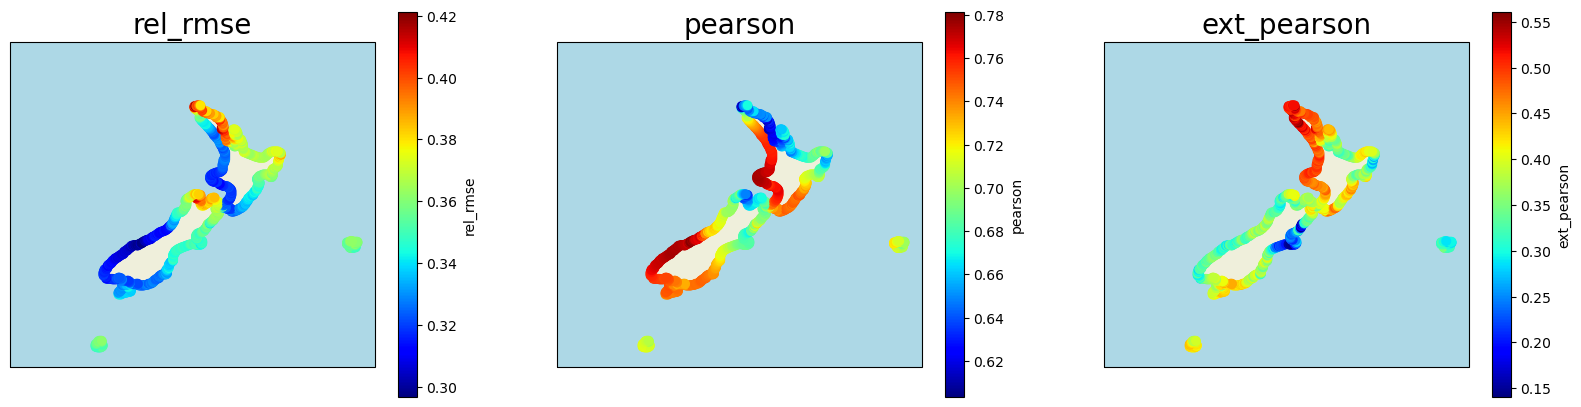

In [5]:
# plot results
if True:
    from sscode.plotting.validation import plot_stats
    plot_stats(stats_regional,plot_stats=['rel_rmse','pearson','ext_pearson'])

### KNN regression in the UHSLC tidal gauges + validation

This part explanation is similar to the one available at **MultiLinear regression models (models_linear.ipynb)**!!

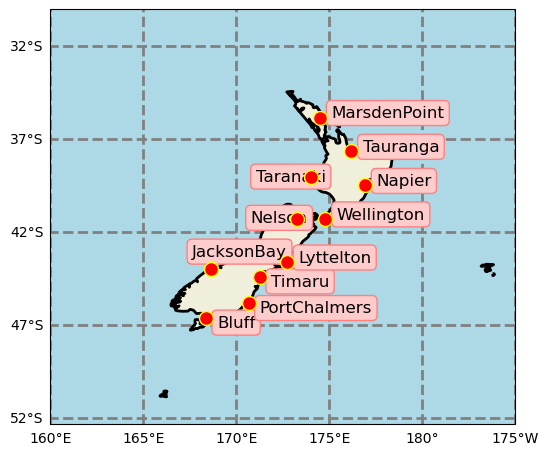

In [6]:
# plot the uhslc tidal-gauges locations
plot_uhslc_locations(load_cfsr_moana_uhslc.validator)


 89 PCs (0.8 expl. variance) will be used to train the model!! 


 KNN regression with 10 neighbors... 



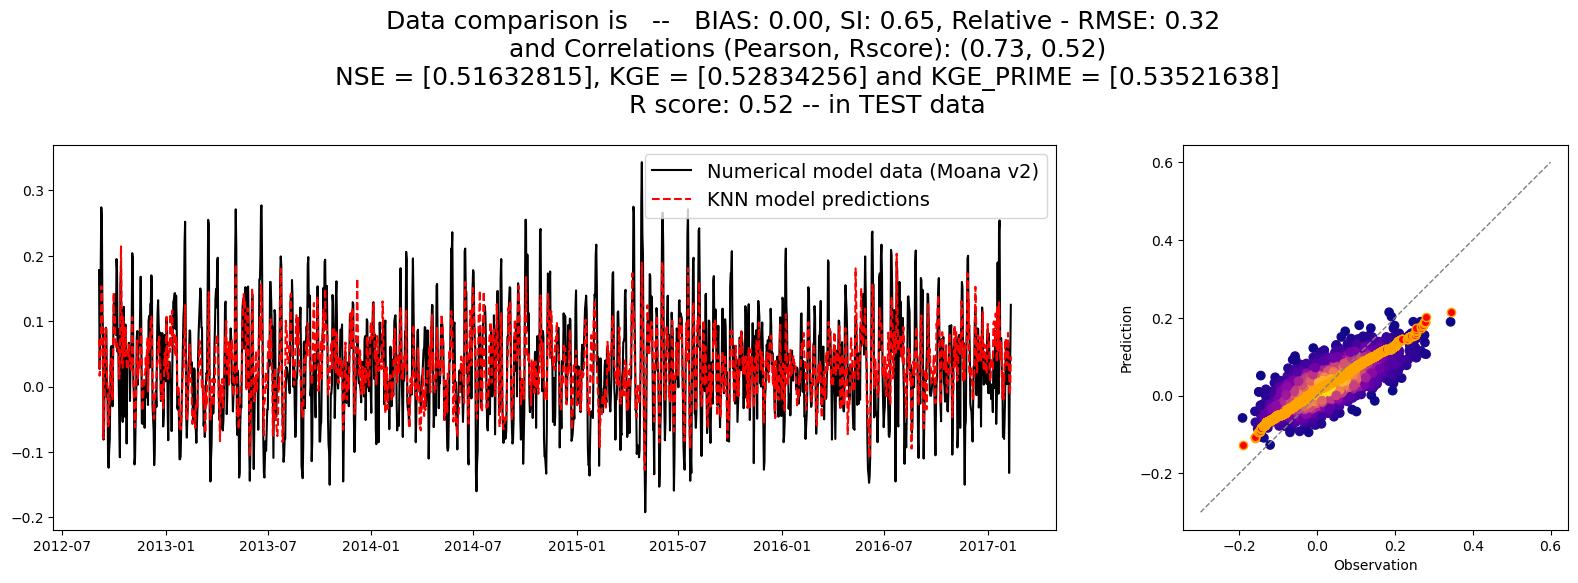

Data comparison is   --   BIAS: 0.00, SI: 0.65, Relative - RMSE: 0.32
 and Correlations (Pearson, Rscore): (0.73, 0.52)
 NSE = [0.51632815], KGE = [0.52834256] and KGE_PRIME = [0.53521638]
 R score: 0.52 -- in TEST data


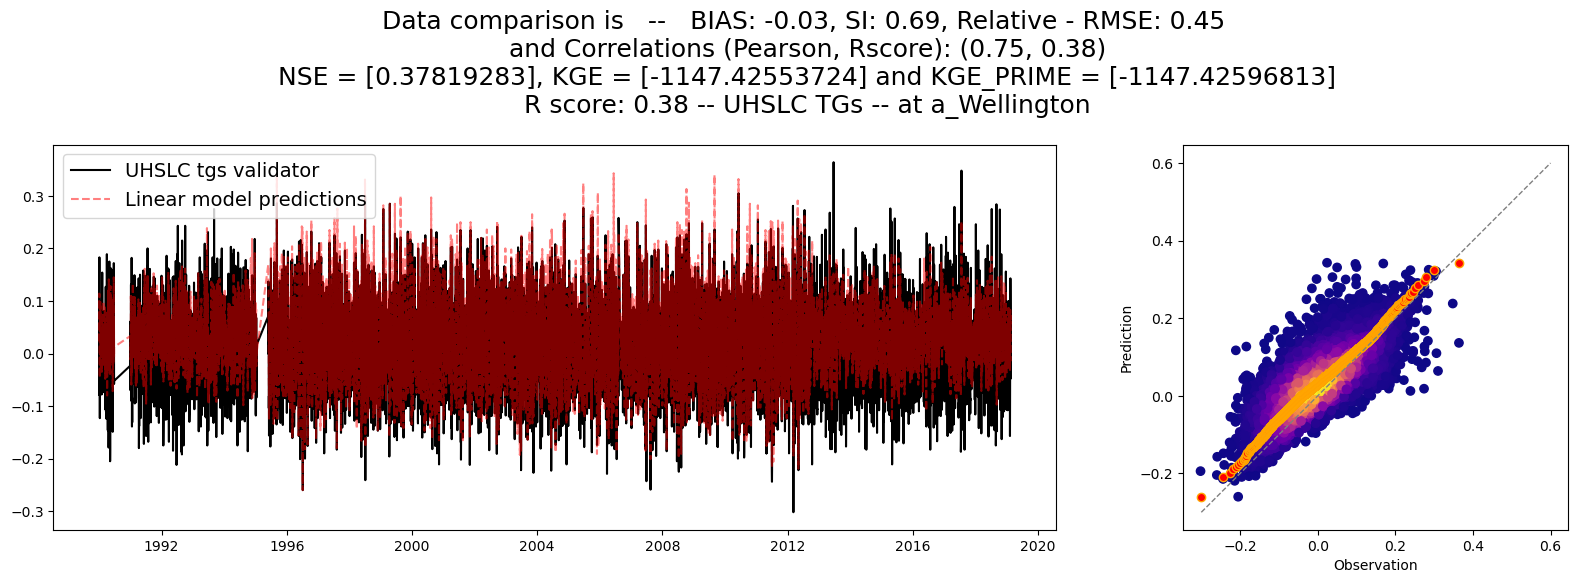


 89 PCs (0.8 expl. variance) will be used to train the model!! 


 KNN regression with 10 neighbors... 



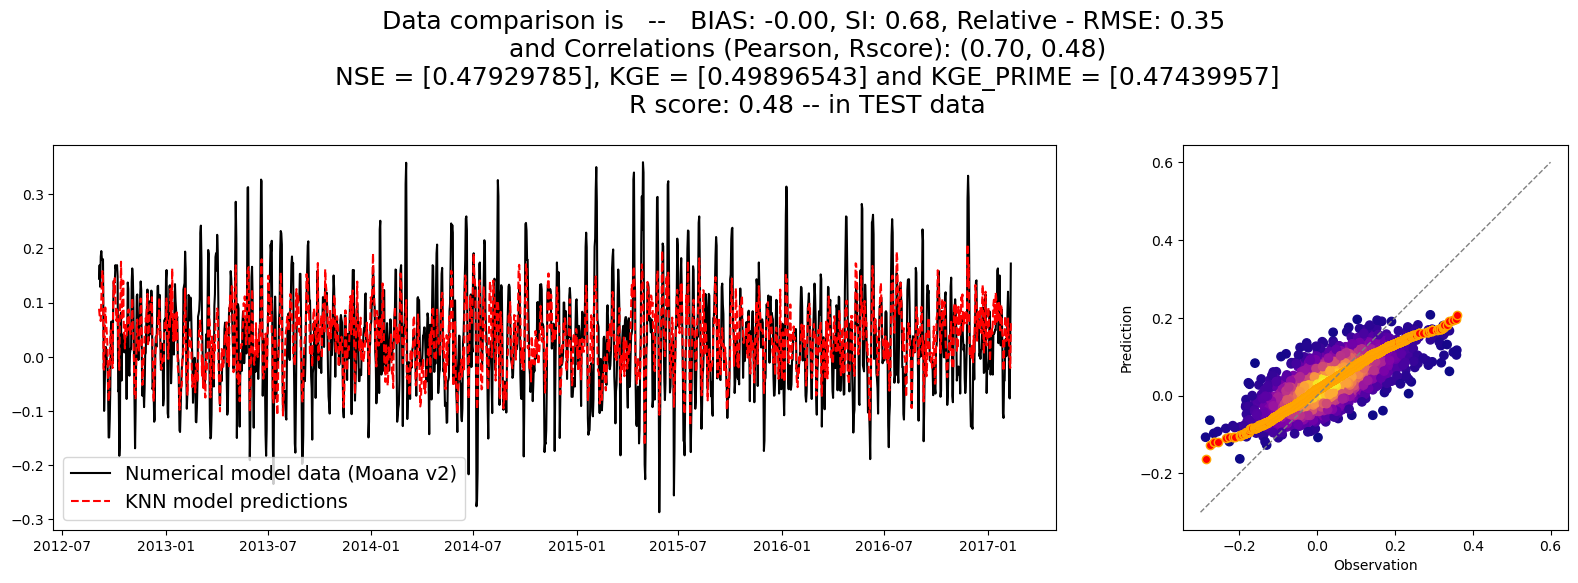

Data comparison is   --   BIAS: -0.00, SI: 0.68, Relative - RMSE: 0.35
 and Correlations (Pearson, Rscore): (0.70, 0.48)
 NSE = [0.47929785], KGE = [0.49896543] and KGE_PRIME = [0.47439957]
 R score: 0.48 -- in TEST data


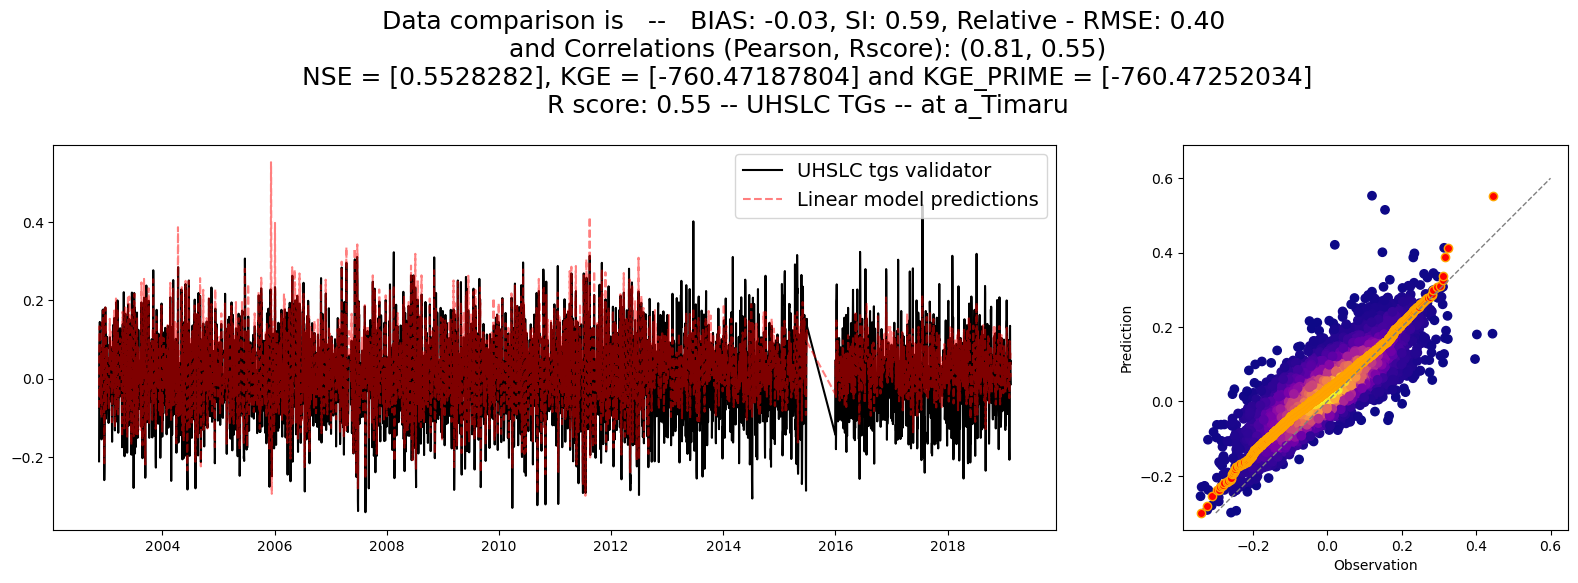


 89 PCs (0.8 expl. variance) will be used to train the model!! 


 KNN regression with 10 neighbors... 



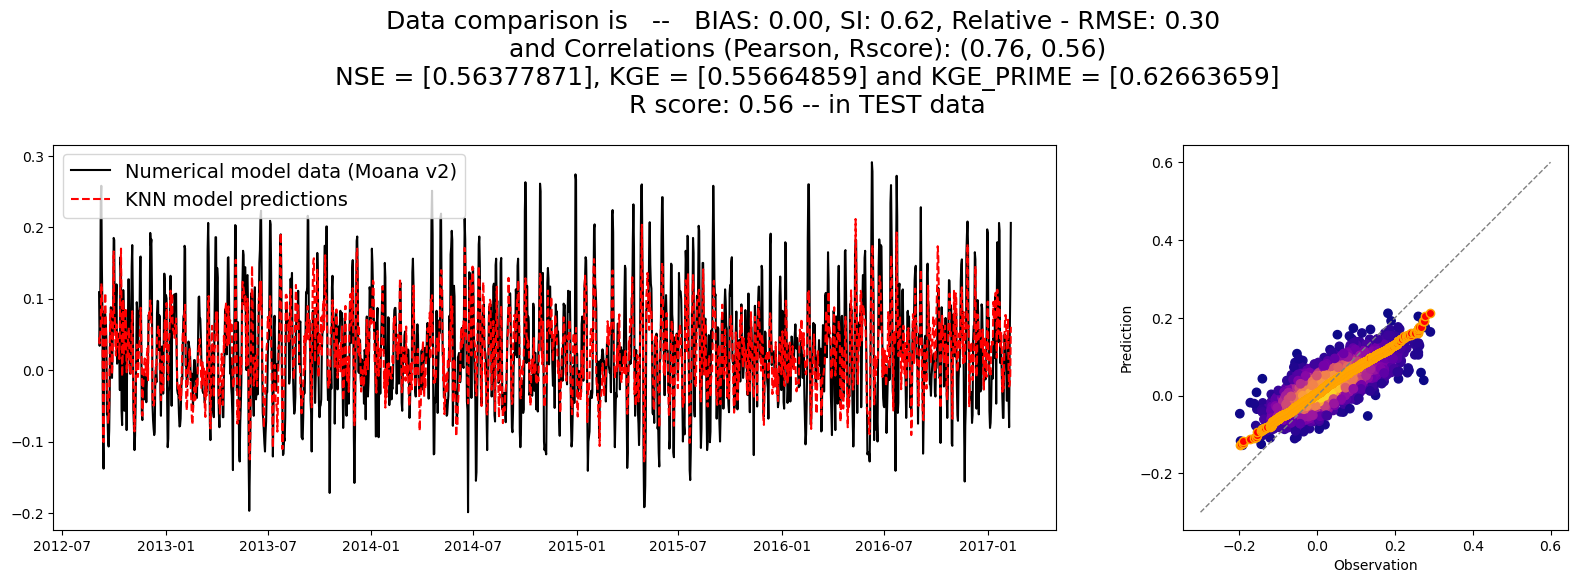

Data comparison is   --   BIAS: 0.00, SI: 0.62, Relative - RMSE: 0.30
 and Correlations (Pearson, Rscore): (0.76, 0.56)
 NSE = [0.56377871], KGE = [0.55664859] and KGE_PRIME = [0.62663659]
 R score: 0.56 -- in TEST data


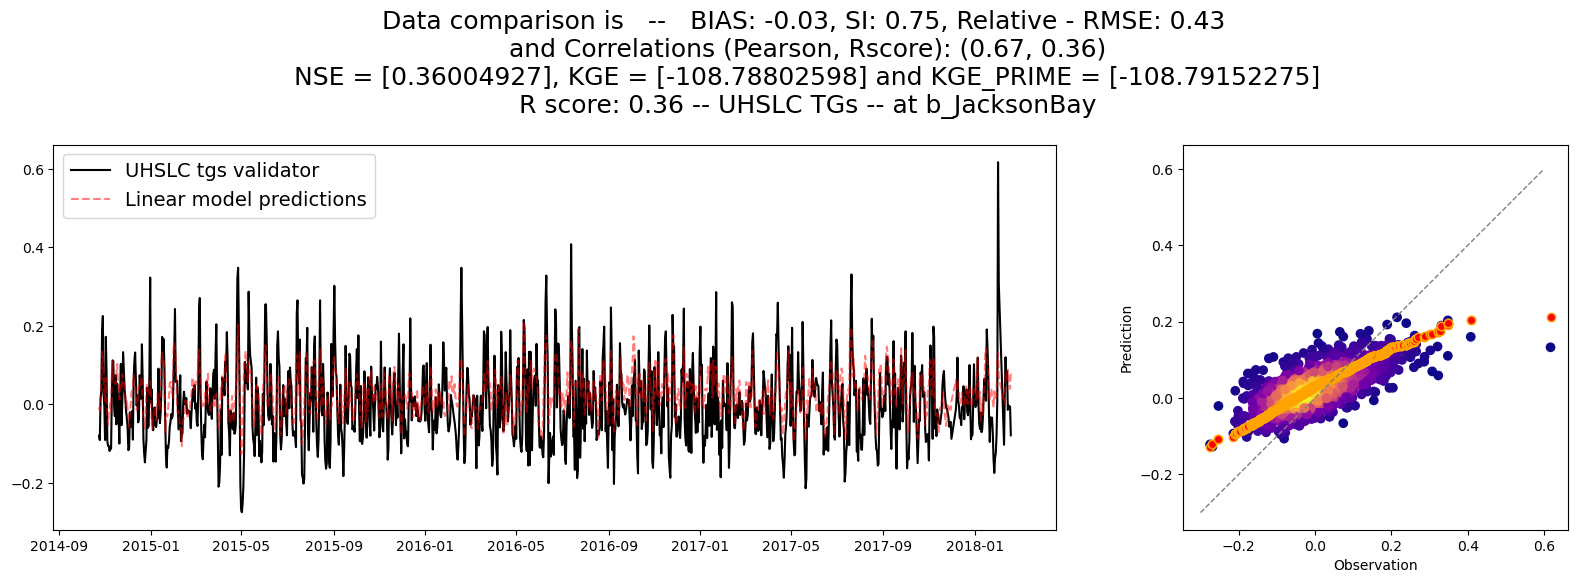


 89 PCs (0.8 expl. variance) will be used to train the model!! 


 KNN regression with 10 neighbors... 



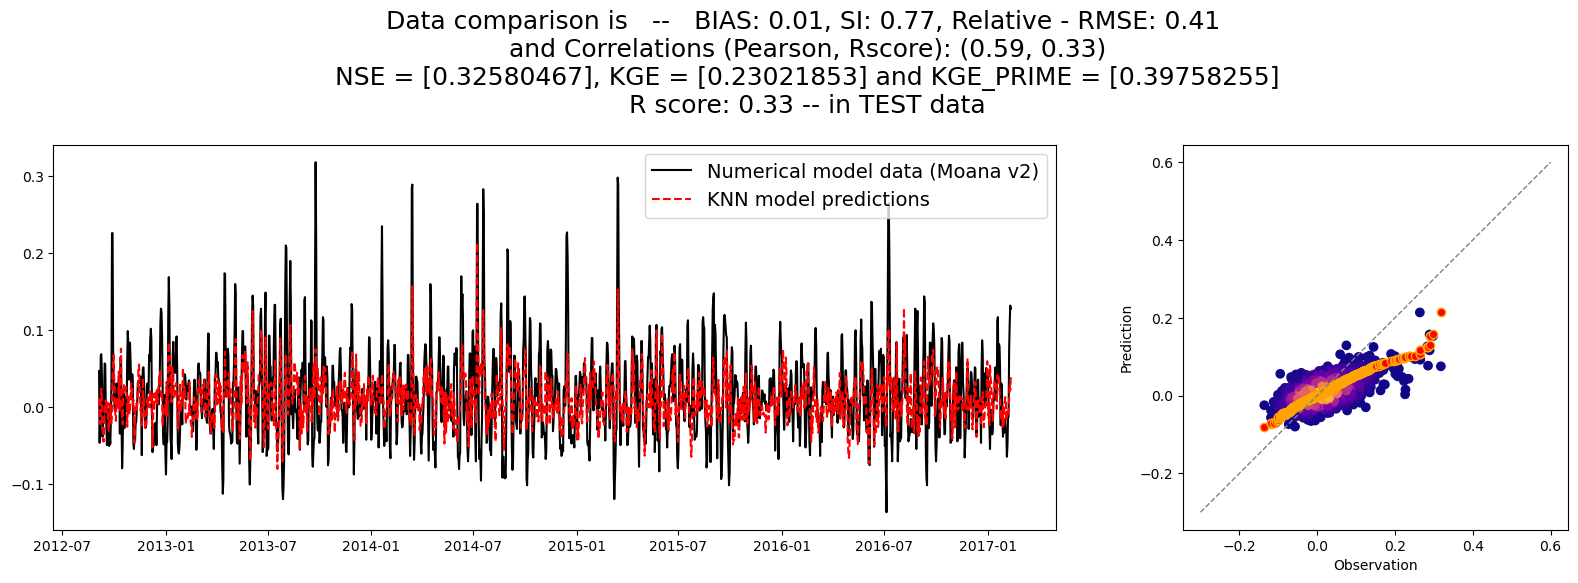

Data comparison is   --   BIAS: 0.01, SI: 0.77, Relative - RMSE: 0.41
 and Correlations (Pearson, Rscore): (0.59, 0.33)
 NSE = [0.32580467], KGE = [0.23021853] and KGE_PRIME = [0.39758255]
 R score: 0.33 -- in TEST data


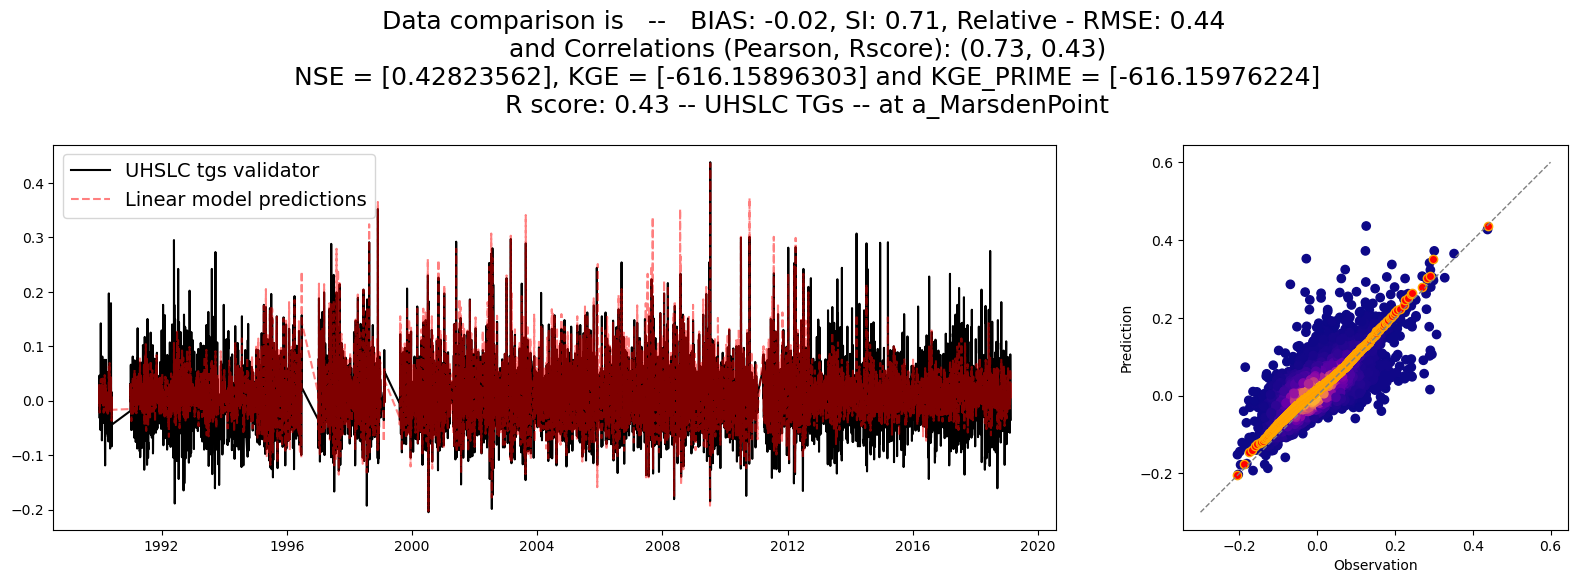


 89 PCs (0.8 expl. variance) will be used to train the model!! 


 KNN regression with 10 neighbors... 



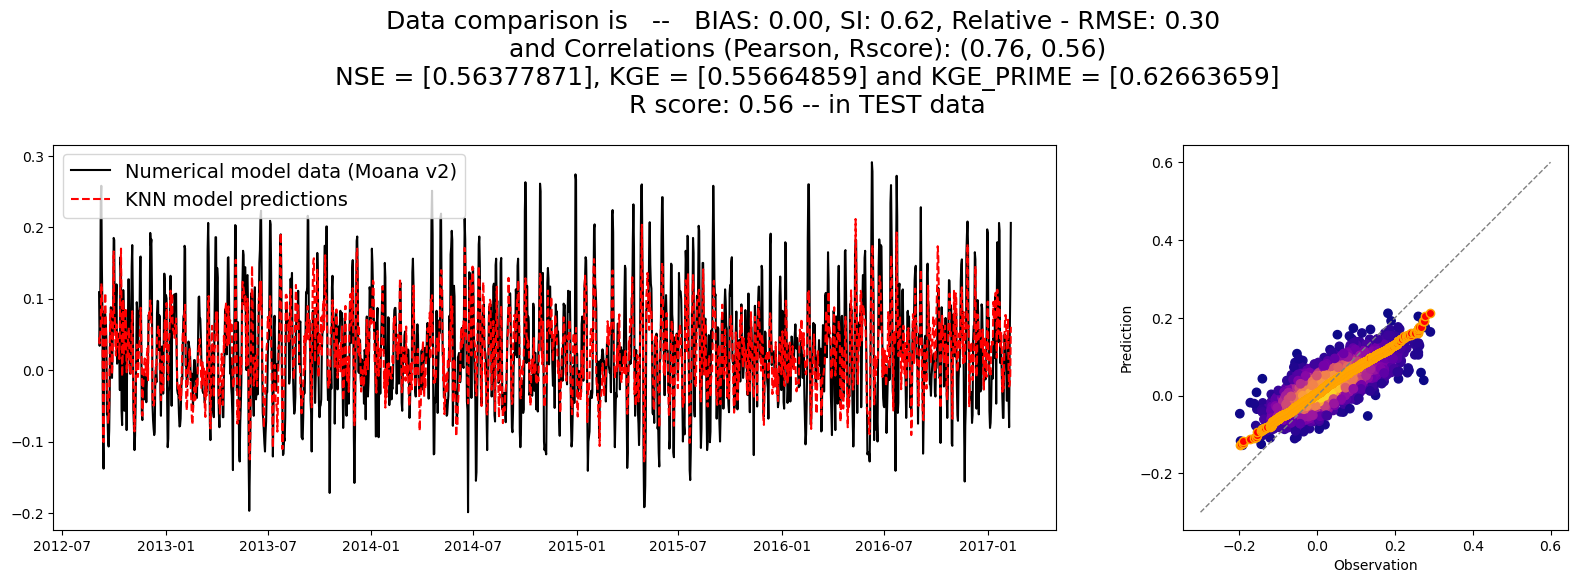

Data comparison is   --   BIAS: 0.00, SI: 0.62, Relative - RMSE: 0.30
 and Correlations (Pearson, Rscore): (0.76, 0.56)
 NSE = [0.56377871], KGE = [0.55664859] and KGE_PRIME = [0.62663659]
 R score: 0.56 -- in TEST data


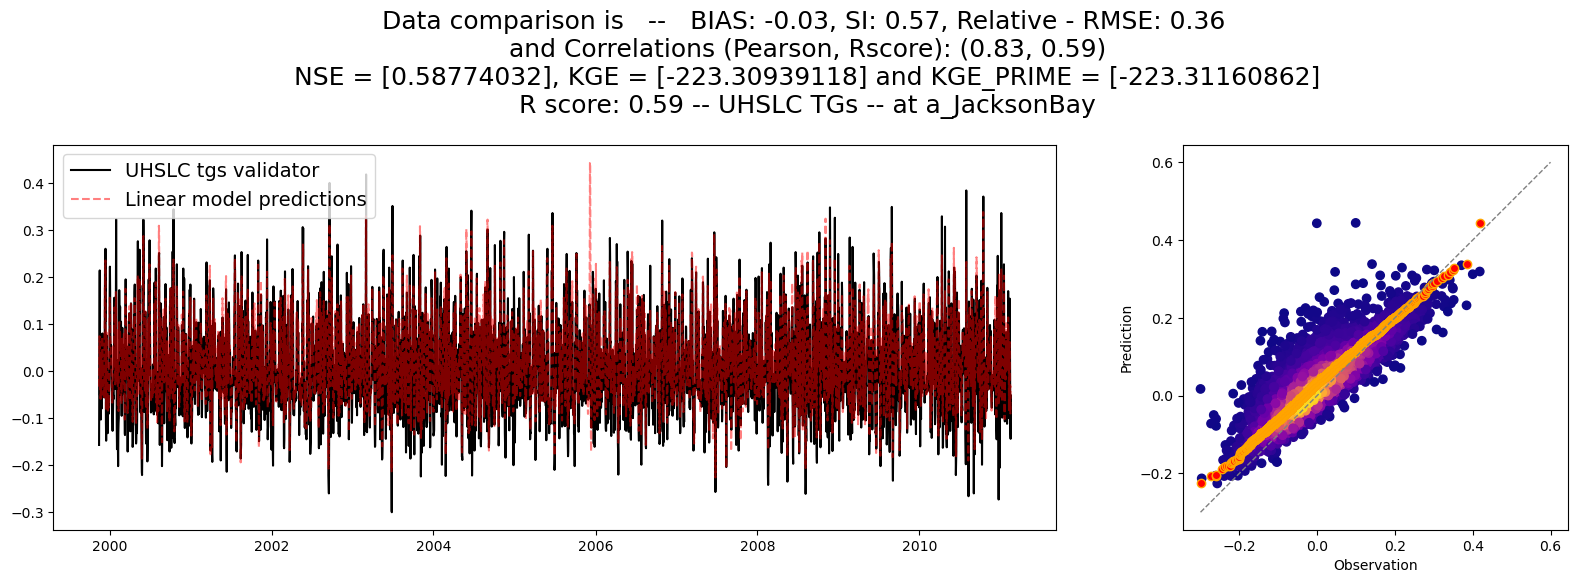


 89 PCs (0.8 expl. variance) will be used to train the model!! 


 KNN regression with 10 neighbors... 



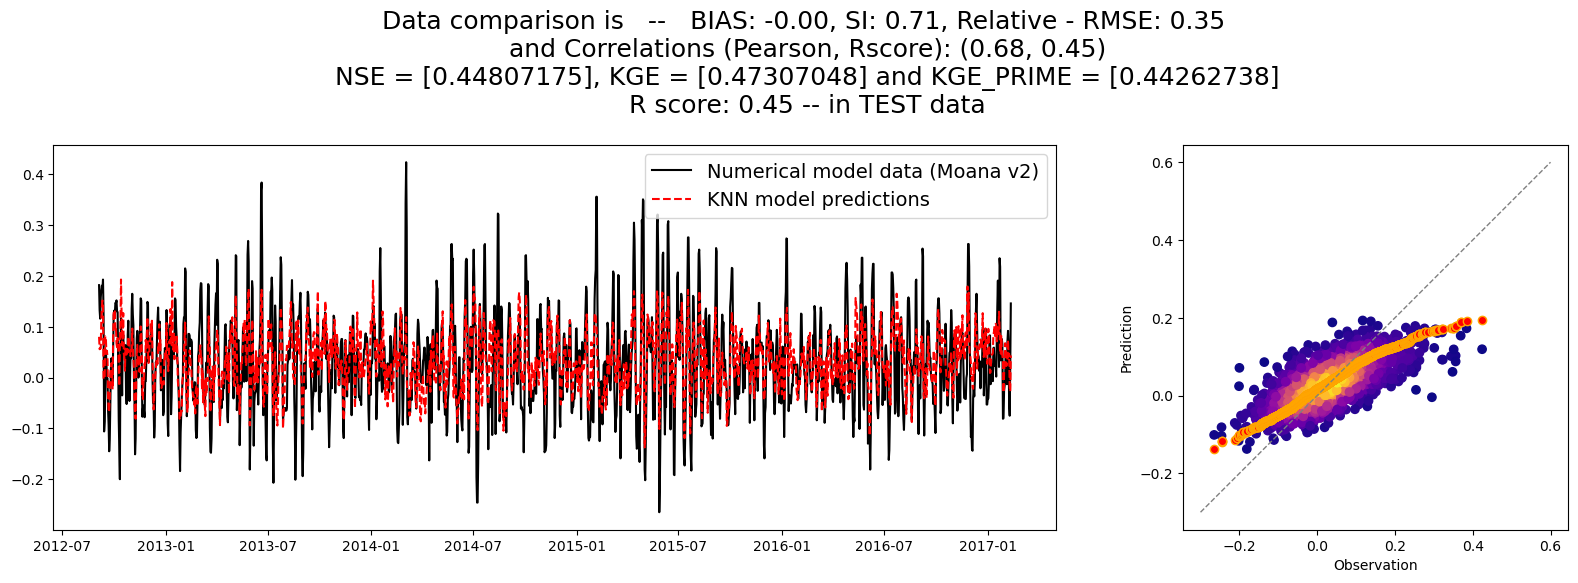

Data comparison is   --   BIAS: -0.00, SI: 0.71, Relative - RMSE: 0.35
 and Correlations (Pearson, Rscore): (0.68, 0.45)
 NSE = [0.44807175], KGE = [0.47307048] and KGE_PRIME = [0.44262738]
 R score: 0.45 -- in TEST data


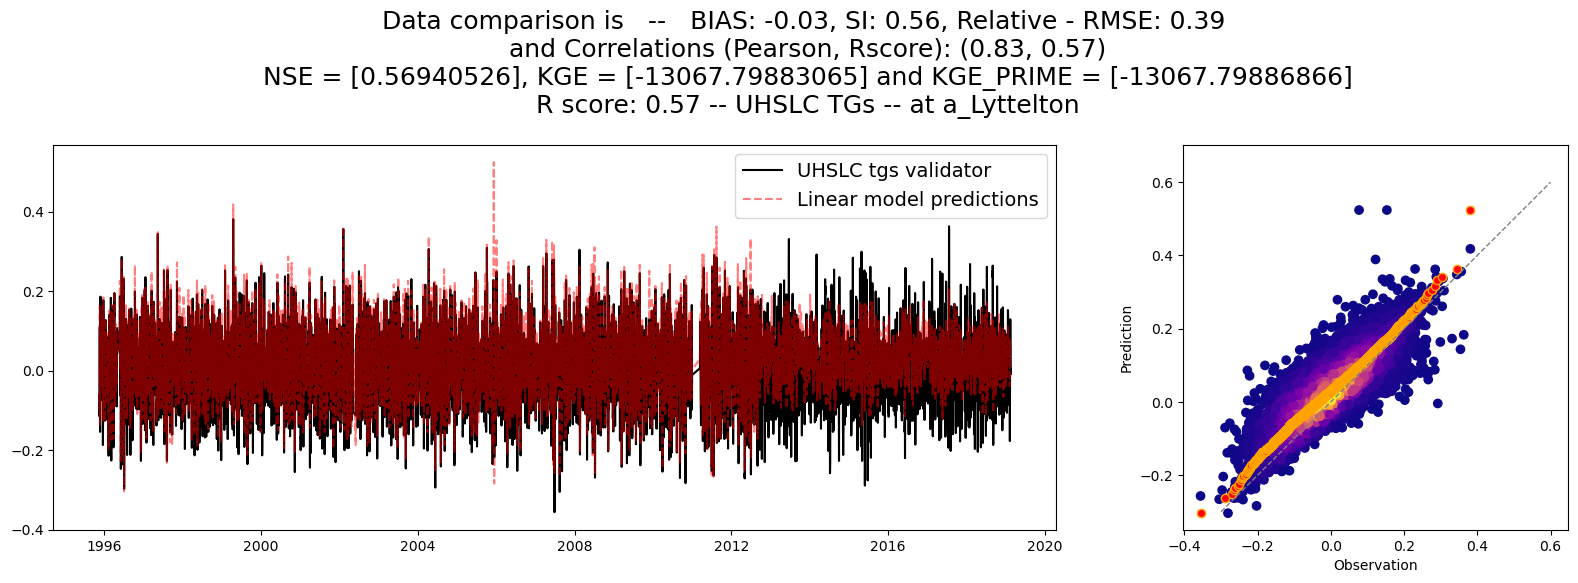


 89 PCs (0.8 expl. variance) will be used to train the model!! 


 KNN regression with 10 neighbors... 



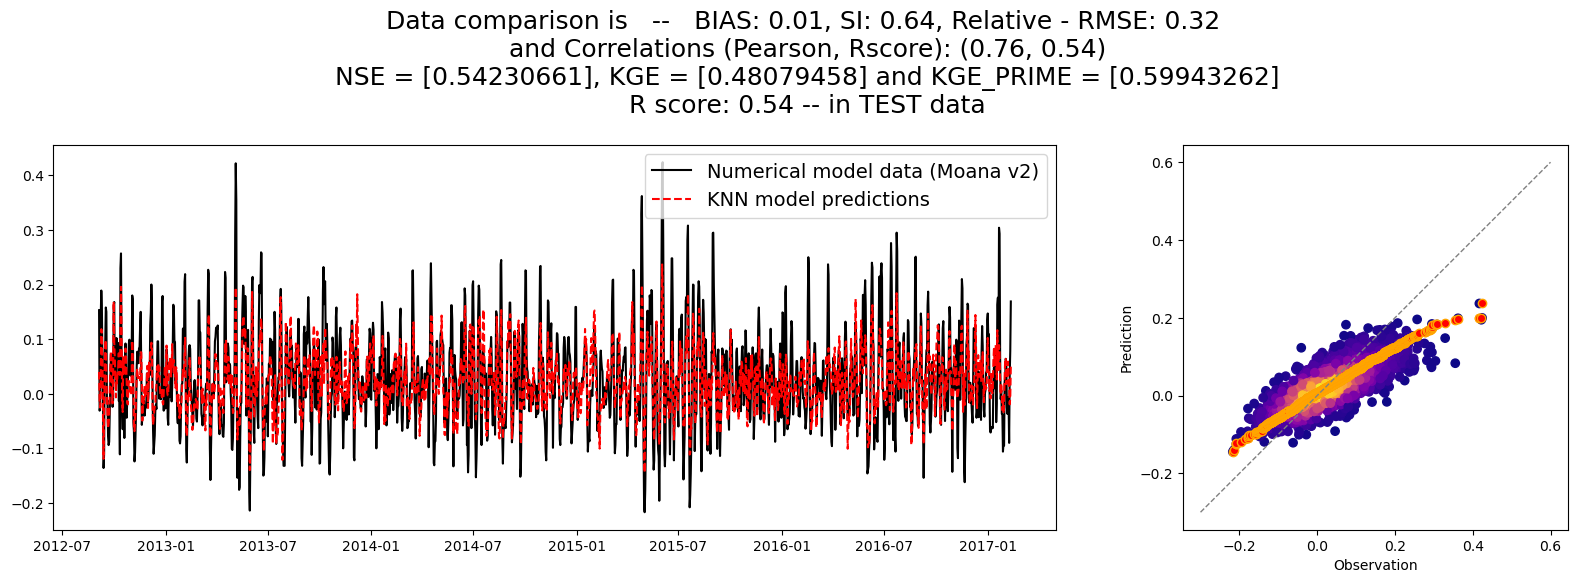

Data comparison is   --   BIAS: 0.01, SI: 0.64, Relative - RMSE: 0.32
 and Correlations (Pearson, Rscore): (0.76, 0.54)
 NSE = [0.54230661], KGE = [0.48079458] and KGE_PRIME = [0.59943262]
 R score: 0.54 -- in TEST data


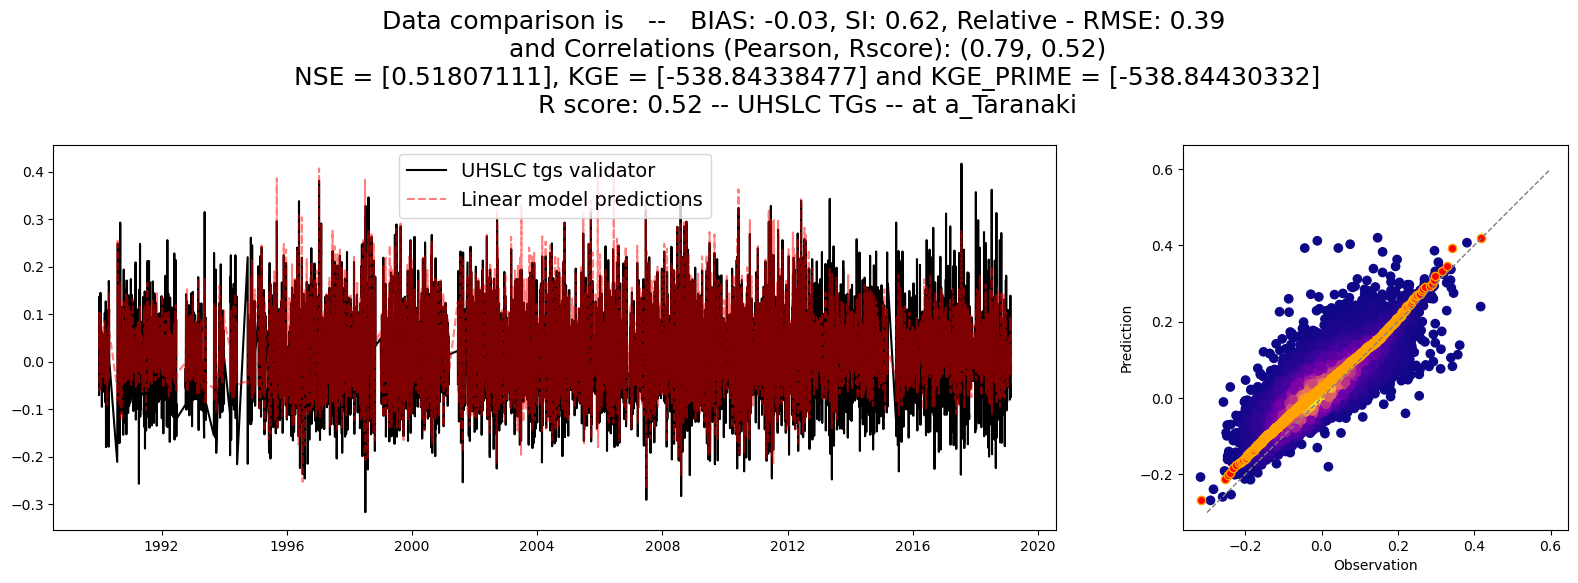


 89 PCs (0.8 expl. variance) will be used to train the model!! 


 KNN regression with 10 neighbors... 



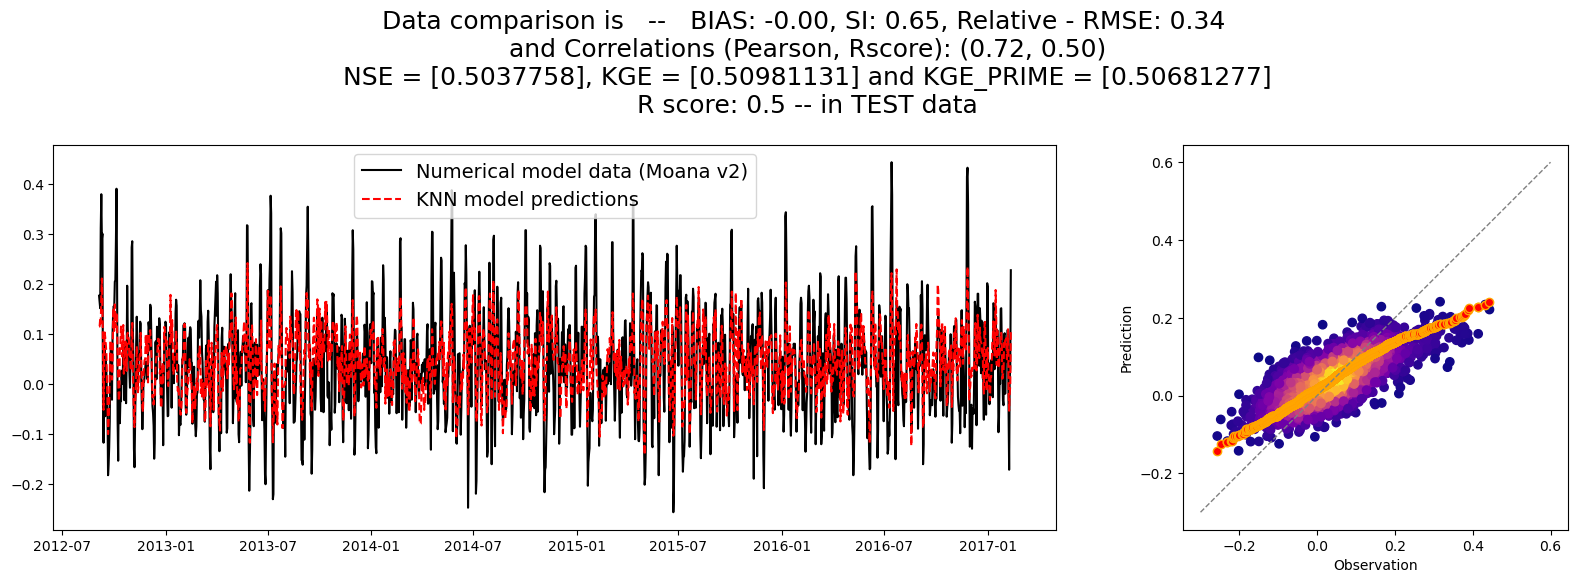

Data comparison is   --   BIAS: -0.00, SI: 0.65, Relative - RMSE: 0.34
 and Correlations (Pearson, Rscore): (0.72, 0.50)
 NSE = [0.5037758], KGE = [0.50981131] and KGE_PRIME = [0.50681277]
 R score: 0.5 -- in TEST data


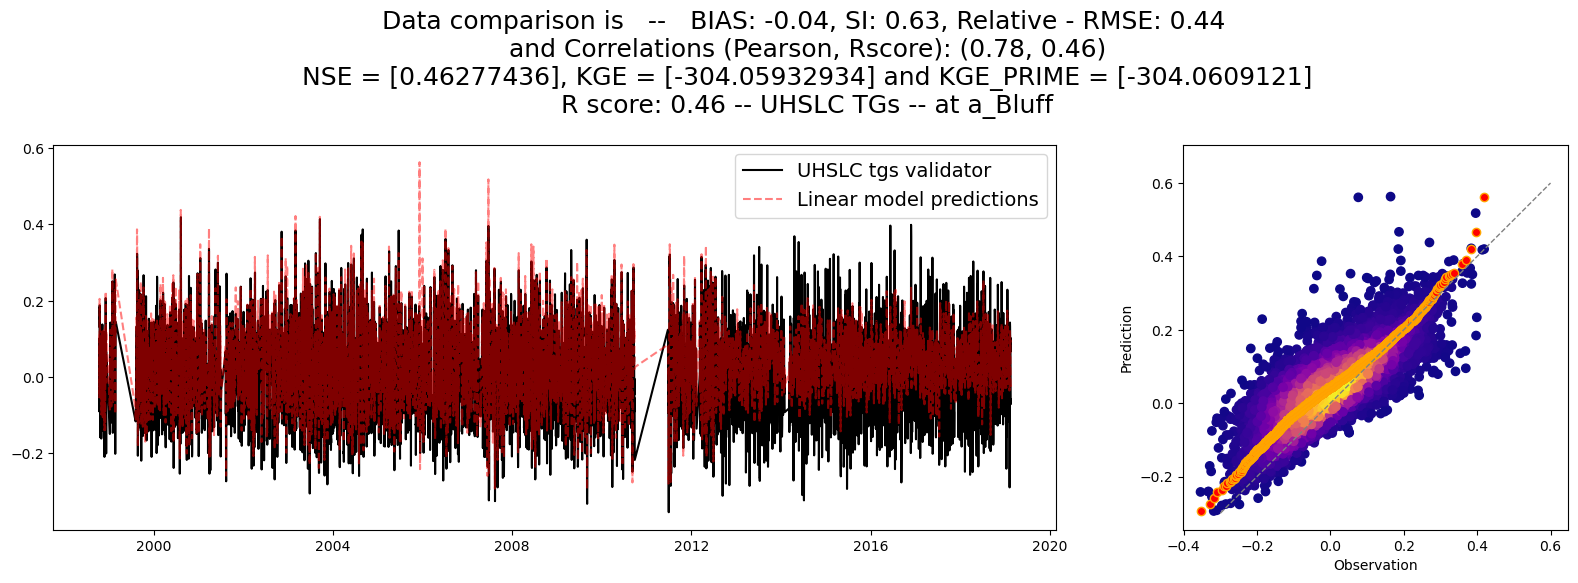


 89 PCs (0.8 expl. variance) will be used to train the model!! 


 KNN regression with 10 neighbors... 



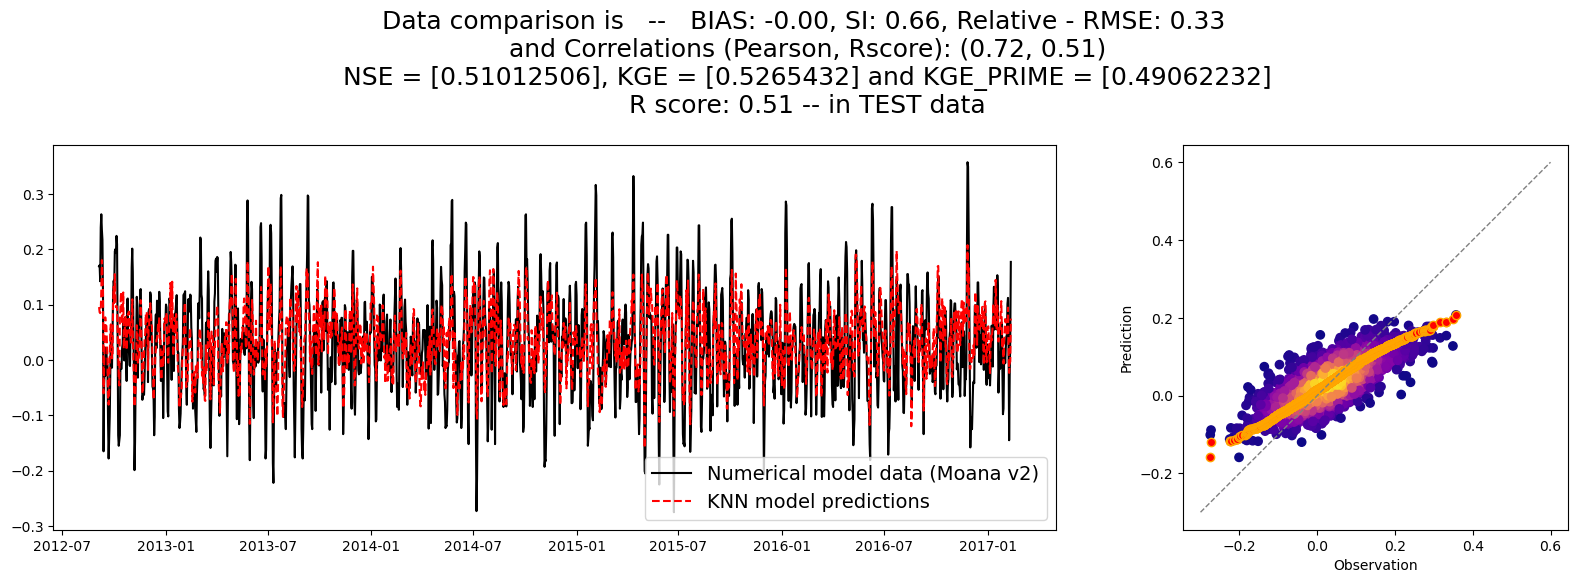

Data comparison is   --   BIAS: -0.00, SI: 0.66, Relative - RMSE: 0.33
 and Correlations (Pearson, Rscore): (0.72, 0.51)
 NSE = [0.51012506], KGE = [0.5265432] and KGE_PRIME = [0.49062232]
 R score: 0.51 -- in TEST data


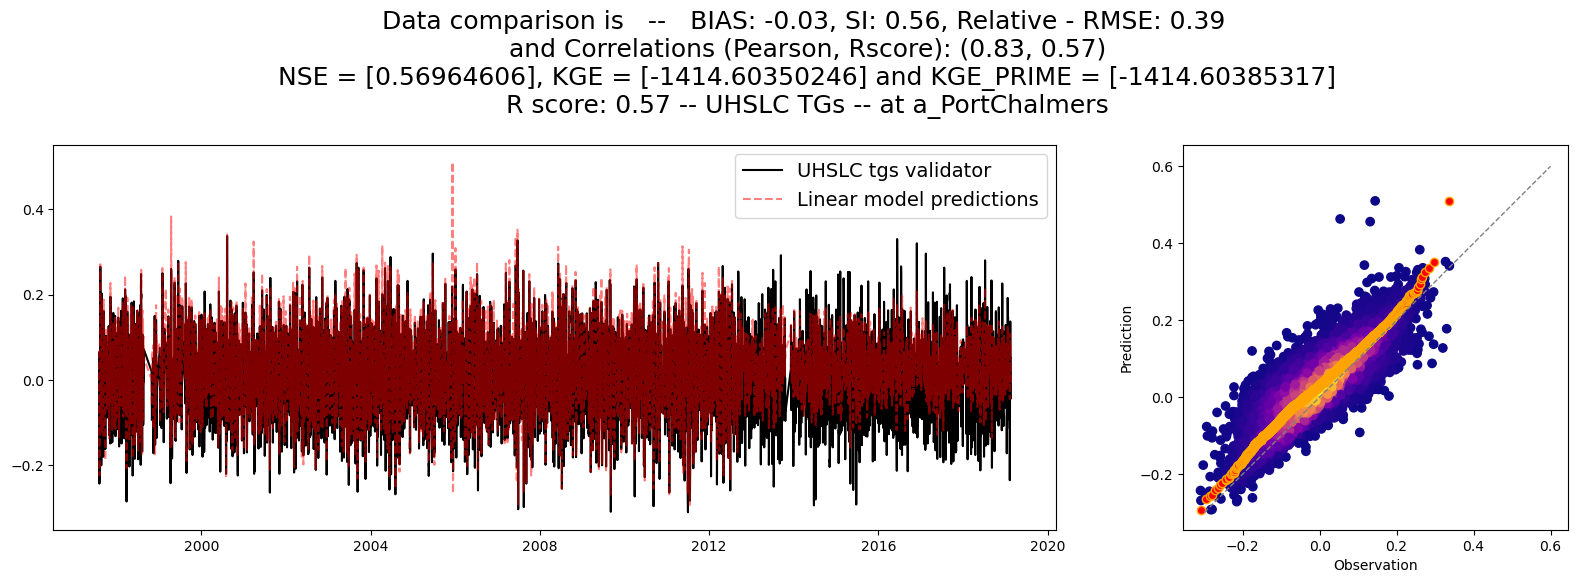


 89 PCs (0.8 expl. variance) will be used to train the model!! 


 KNN regression with 10 neighbors... 



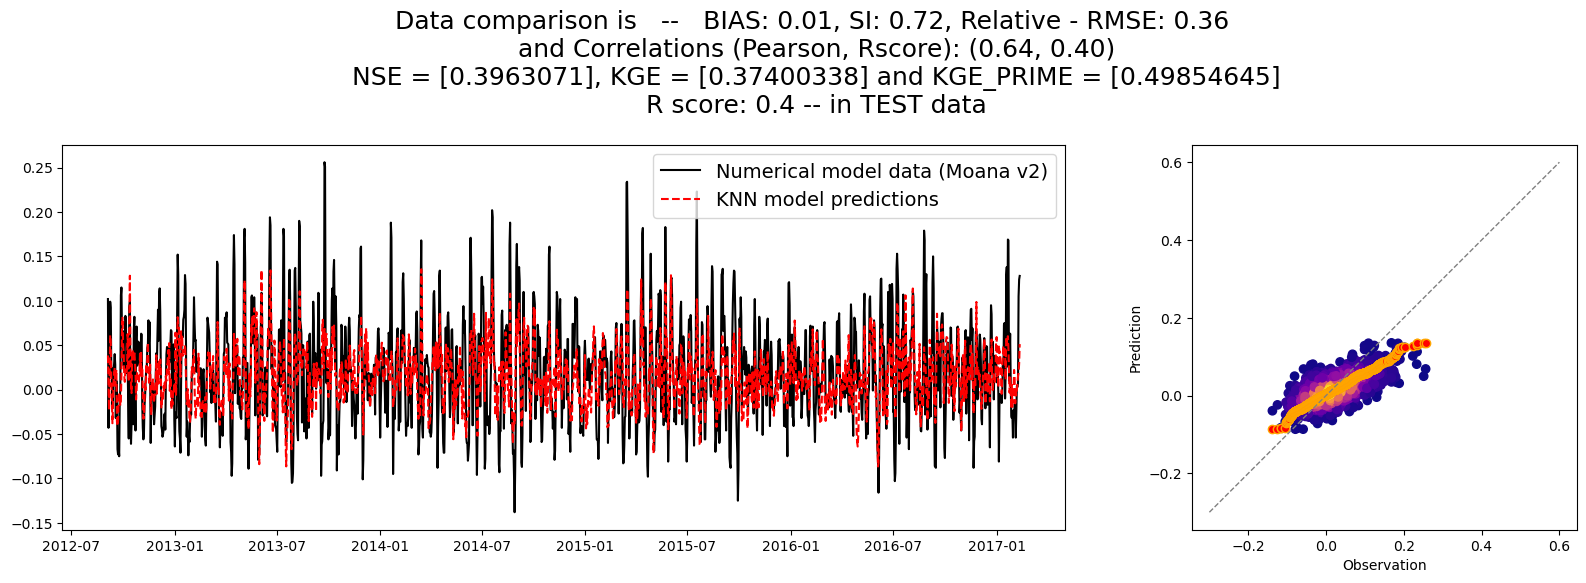

Data comparison is   --   BIAS: 0.01, SI: 0.72, Relative - RMSE: 0.36
 and Correlations (Pearson, Rscore): (0.64, 0.40)
 NSE = [0.3963071], KGE = [0.37400338] and KGE_PRIME = [0.49854645]
 R score: 0.4 -- in TEST data


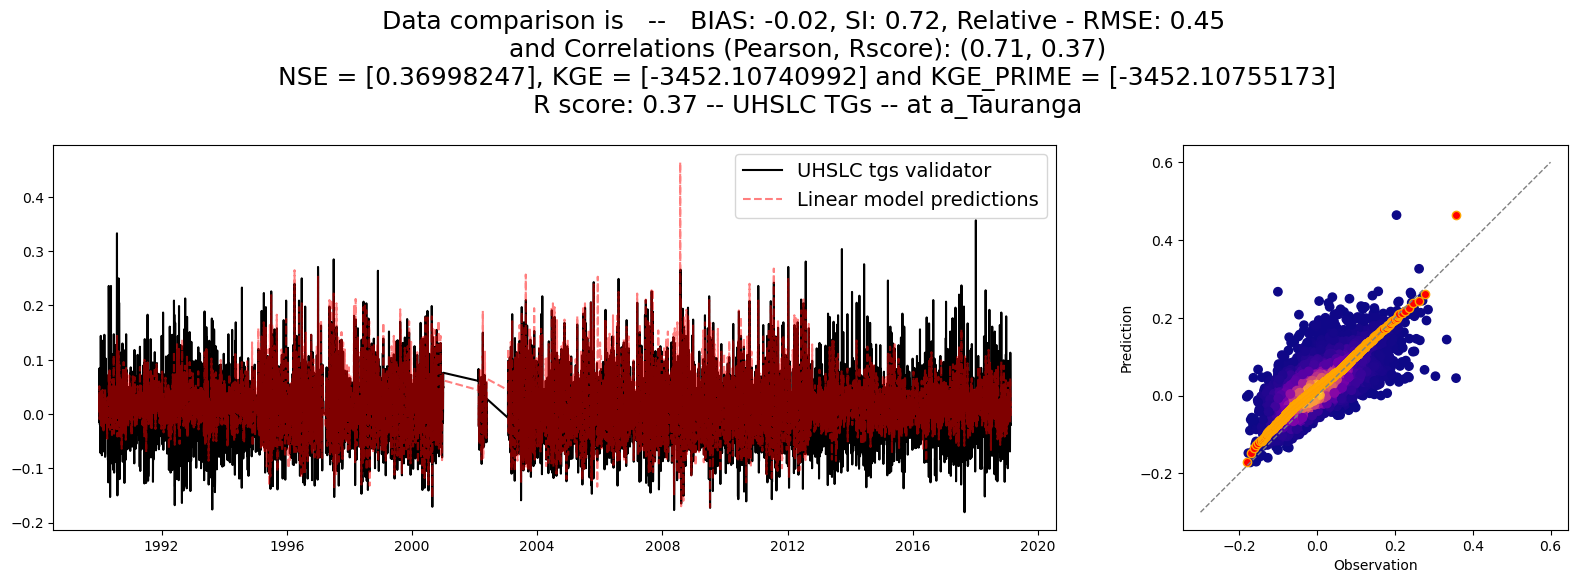


 89 PCs (0.8 expl. variance) will be used to train the model!! 


 KNN regression with 10 neighbors... 



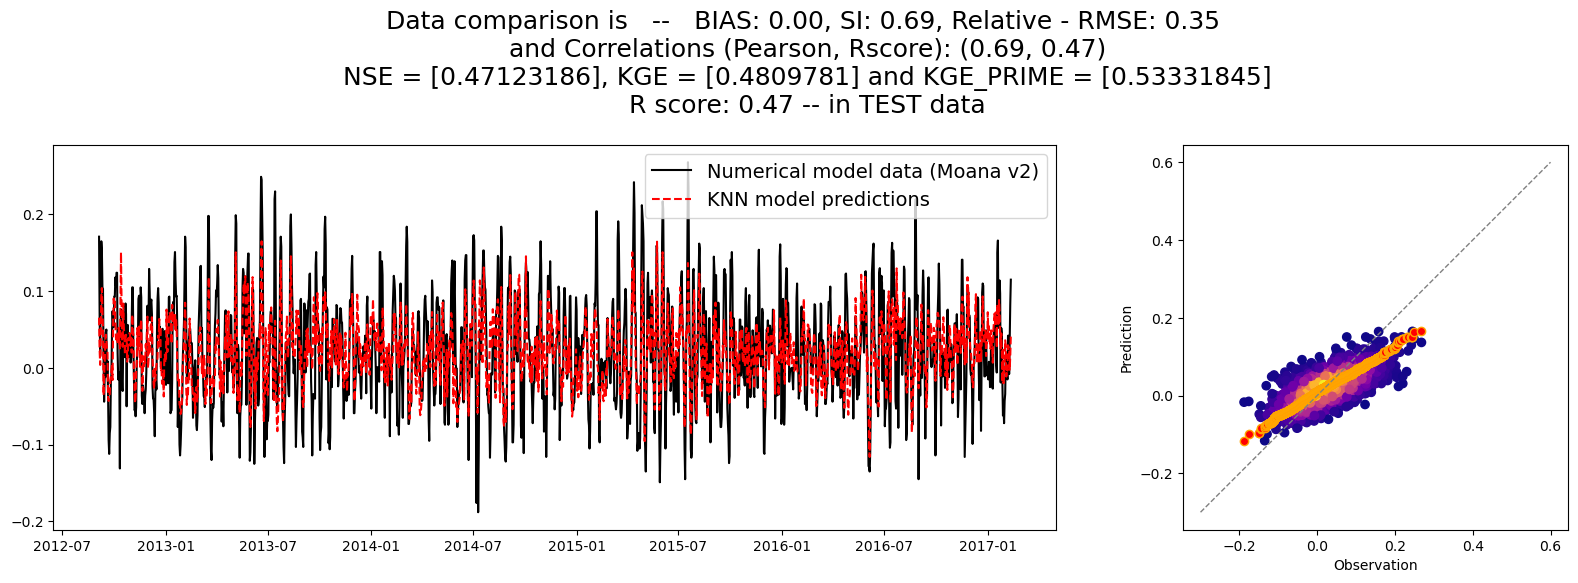

Data comparison is   --   BIAS: 0.00, SI: 0.69, Relative - RMSE: 0.35
 and Correlations (Pearson, Rscore): (0.69, 0.47)
 NSE = [0.47123186], KGE = [0.4809781] and KGE_PRIME = [0.53331845]
 R score: 0.47 -- in TEST data


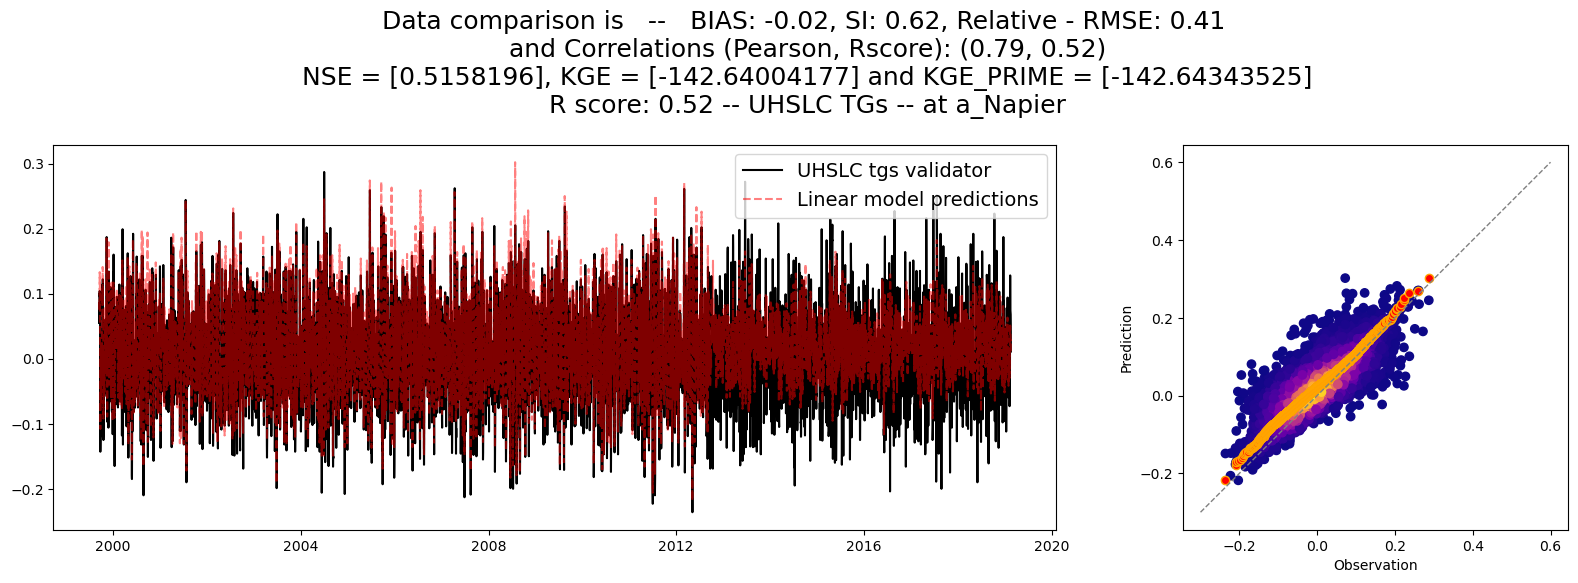


 89 PCs (0.8 expl. variance) will be used to train the model!! 


 KNN regression with 10 neighbors... 



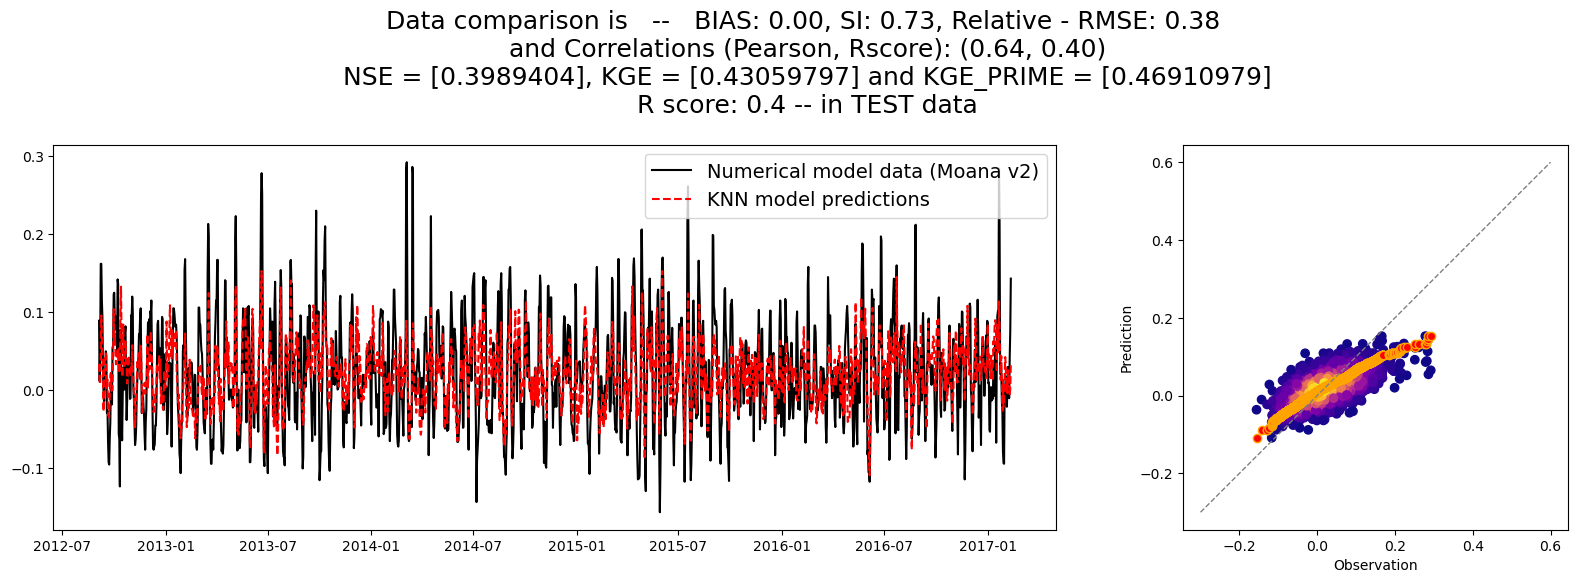

Data comparison is   --   BIAS: 0.00, SI: 0.73, Relative - RMSE: 0.38
 and Correlations (Pearson, Rscore): (0.64, 0.40)
 NSE = [0.3989404], KGE = [0.43059797] and KGE_PRIME = [0.46910979]
 R score: 0.4 -- in TEST data


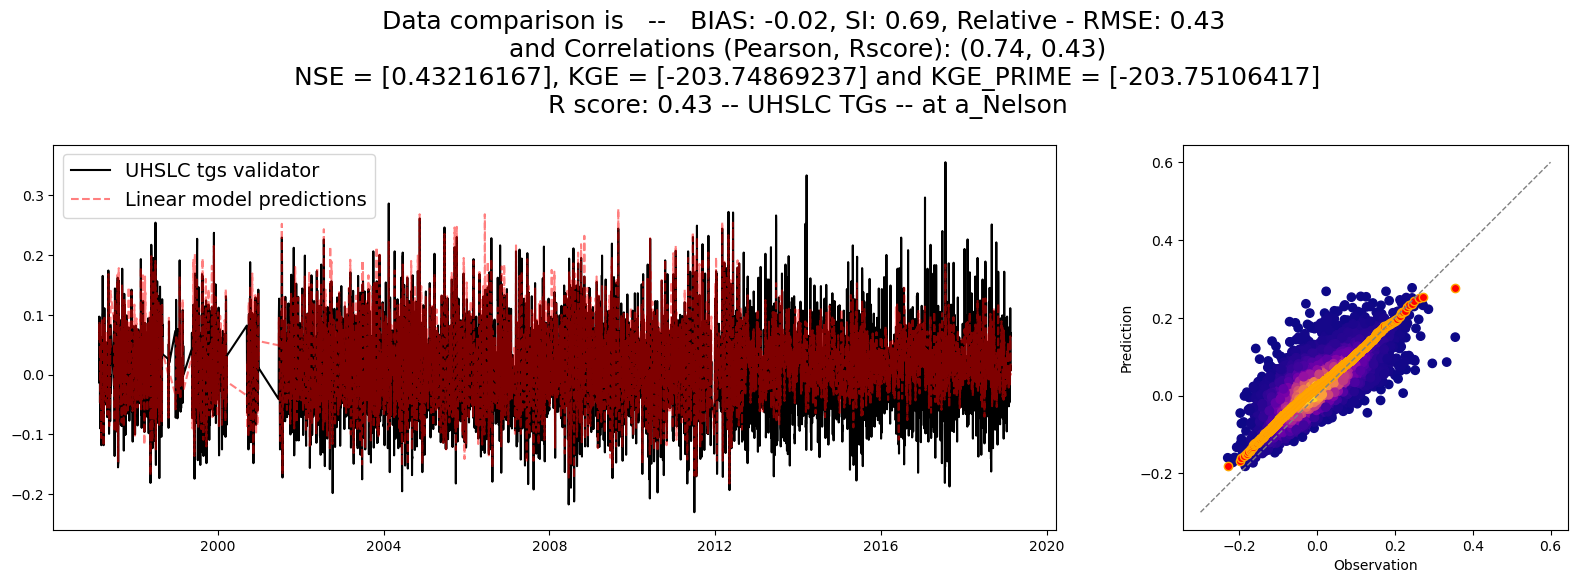

In [7]:
# validate model with tgs
stats = []
# select sites and append closest to UHSLC tgs
clos_to_uhslc = [689, 328, 393, 1327, 393, 480, 999, 116, 224, 1124, 949, 708]
# check behavior with normalized PCs
from sklearn.preprocessing import StandardScaler
pcs_cfsr = pcs_cfsr.assign({
    'PCs_stan': (('time','n_components'), StandardScaler().fit_transform(pcs_cfsr.PCs.values))
})
for istat,stat in enumerate(clos_to_uhslc):
    ss_moana = load_cfsr_moana_uhslc.predictand.sel(site=stat)\
        .load().resample(time='1D').max()
    stats_stat, model, train_times = KNN_Regression(
        pcs_cfsr, ss_moana, 
        validator=(
            True,load_cfsr_moana_uhslc.validator.isel(name=istat),'ss'
        ), 
        plot_results=True, verbose=True, k_neighbors=10, 
        train_size=0.8, percentage_PCs=0.8
    )
    # stats_stat, model, train_times = KNN_Regression(
    #     pcs_cfsr, ss_moana, X_set_var='PCs_stan',
    #     validator=(
    #         True,load_cfsr_moana_uhslc.validator.isel(name=istat),'ss'
    #     ), 
    #     plot_results=True, verbose=True, k_neighbors=10, 
    #     train_size=0.8, percentage_PCs=0.8
    # )

### Check KNN reconstructions

Now, we visualize how the knn algorithm works in the prediction task...

```{warning}
TODO: add explanations!!
```

In [8]:
# import custom plotting variables
from sscode.config import default_location, default_region
from sscode.plotting.config import _figsize
from sscode.plotting.utils import plot_ccrs_nz

# find similarities between real and kneighbors
n_times = 2 # number of validations/plots
k_neighbors = 1 # number of neighbors to search
# plotting fig and axes
for time in np.random.randint(0,len(train_times),n_times):
    fig, axes = plt.subplots(
        ncols=3,figsize=_figsize,
        subplot_kw={
            'projection':ccrs.PlateCarree(
                central_longitude=default_location[0]
            )
        }
    )
    real = load_cfsr_moana_uhslc.predictor_slp.isel(time=time)
    real.plot(
        cmap='bwr',vmin=101300-2000,vmax=101300+2000,ax=axes[0],
        transform=ccrs.PlateCarree()
    )
    predicted = load_cfsr_moana_uhslc.predictor_slp.isel(
        time=model.kneighbors(
            pcs_cfsr.isel(time=time).PCs[:388].values.reshape(1,-1),
            # TODO: edit pcs limit above if error is raised!!
            k_neighbors
        )[1][0]
    ).mean(dim='time')
    predicted.plot(
        cmap='bwr',vmin=101300-2000,vmax=101300+2000,ax=axes[1],
        transform=ccrs.PlateCarree()
    )
    (real-predicted).plot(
        cmap='bwr',vmin=-2000,vmax=+2000,ax=axes[2],
        transform=ccrs.PlateCarree()
    )
    axes[1].set_title('Predicted SLP - k_neigh = {}'.format(k_neighbors))
    axes[2].set_title('SLP difference in [mbar·100]')
    plot_ccrs_nz(axes,plot_region=(True,default_region),plot_land=False,
                 plot_labels=(False,None,None))

ValueError: Incompatible dimension for X and Y matrices: X.shape[1] == 388 while Y.shape[1] == 89

### knn regression - Ana's paper

In the two following cells, we try to replicate the same analysis that we made with the linear regression, but this time with the knn regressor...

In [ ]:
# knn regression in kapiti island
ss_kapiti = load_private_tgs().sel(name='Kapiti_Is').resample(time='1D').max()
stats_kapiti, kapiti_model, train_times = KNN_Regression(
    pcs_cfsr, ss_kapiti, plot_results=True, verbose=True, max_neighbors=50
)
print(f'\n\n -- METRICS -- \n\n {stats_kapiti} \n\n obtained with {kapiti_model} !!')

In [ ]:
# knn regression in green island
ss_green = load_private_tgs().sel(name='Green_Is').resample(time='1D').max()
stats_green, green_model, train_times = KNN_Regression(
    pcs_cfsr, ss_green, plot_results=True, verbose=True, max_neighbors=50
)
print(f'\n\n -- METRICS -- \n\n {stats_green} \n\n obtained with {green_model} !!')

In [ ]:
# knn regression in green island (local predictor)
ss_green = load_private_tgs().sel(name='Green_Is').resample(time='1D').max()
stats_green_local, green_model_local, train_times = KNN_Regression(
    PCA_DynamicPred(
        load_cfsr_moana_uhslc.predictor_slp, 
        calculate_gradient=True, time_lapse=3,
        region=(True, (
            ss_green.longitude.values-2.2,
            ss_green.longitude.values+2.2,
            ss_green.latitude.values+2.2,
            ss_green.latitude.values-2.2
        )),
        pca_plot=(True,False,2), verbose=True
    )[0], 
    ss_green, plot_results=True, verbose=True,
    max_neighbors=12, train_size=0.7
)
print(f'\n\n -- METRICS -- \n\n {stats_green_local} \n\n obtained with {green_model_local} !!')

### Compare wind's module with projected winds!!

In [ ]:
# we first re-project the winds in JacksonBay
from sscode.utils import calculate_relative_winds
jbay_ss = load_cfsr_moana_uhslc.validator.sel(name='a_JacksonBay')\
    .resample(time='1D').max().dropna(dim='time')
jbay_lon, jbay_lat = jbay_ss.longitude.values, jbay_ss.latitude.values
jbay_wind = calculate_relative_winds(
    location=(jbay_lon,jbay_lat), # JacksonBay location
    uw=load_cfsr_moana_uhslc.predictor_wind.U_GRD_L103,
    vw=load_cfsr_moana_uhslc.predictor_wind.V_GRD_L103
) # jbay_wind

In [ ]:
delta_lon, delta_lat = 2.1, 2.1
time_lapse = 3
# knn model with wind's module
stats_stat, model, pcs_to_use = KNN_Regression(
    PCA_DynamicPred(
        load_cfsr_moana_uhslc.predictor_slp,
        calculate_gradient=False, # no gradient is calculated
        winds=(True,jbay_wind),time_lapse=time_lapse,
        wind_vars=('wind_magnitude','lon','lat'),
        region=(True,(
            jbay_lon-delta_lon,jbay_lon+delta_lon,
            jbay_lat+delta_lat,jbay_lat-delta_lat
        )),
        pca_ttls=['SLP in t','WINDs in t',
                  'SLP in t-1','WINDs in t-1',
                  'SLP in t-2','WINDs in t-2'],
        pca_plot=(True,False,2)
    )[0], jbay_ss, plot_results=True, verbose=True
)
# knn model with projected winds
stats_stat, model, pcs_to_use = KNN_Regression(
    PCA_DynamicPred(
        load_cfsr_moana_uhslc.predictor_slp,
        calculate_gradient=False, # no gradient is calculated
        winds=(True,jbay_wind),time_lapse=time_lapse,
        wind_vars=('wind_proj','lon','lat'),
        region=(True,(
            jbay_lon-delta_lon,jbay_lon+delta_lon,
            jbay_lat+delta_lat,jbay_lat-delta_lat
        )),
        pca_ttls=['SLP in t','WINDs in t',
                  'SLP in t-1','WINDs in t-1',
                  'SLP in t-2','WINDs in t-2'],
        pca_plot=(True,False,2)
    )[0], jbay_ss, plot_results=True, verbose=True
)
# knn model with masked projected winds
stats_stat, model, pcs_to_use = KNN_Regression(
    PCA_DynamicPred(
        load_cfsr_moana_uhslc.predictor_slp,
        calculate_gradient=False, # no gradient is calculated
        winds=(True,jbay_wind),time_lapse=time_lapse,
        wind_vars=('wind_proj_mask','lon','lat'),
        region=(True,(
            jbay_lon-delta_lon,jbay_lon+delta_lon,
            jbay_lat+delta_lat,jbay_lat-delta_lat
        )),
        pca_ttls=['SLP in t','WINDs in t',
                  'SLP in t-1','WINDs in t-1',
                  'SLP in t-2','WINDs in t-2'],
        pca_plot=(True,False,2)
    )[0], jbay_ss, plot_results=True, verbose=True, k_neighbors=3
)

## KNN regression with local predictor

In the following cell, a knn regression is performed over all the domain of the Moana v2 hindcast nearshore, having the local pcs (slp + gradient) as the predictor. Moreover, we plot the obtained results, which are also saved in our `data/statistics` folder, with the name `stats_knn_local_daily.nc`. Notice that, with the regional predictor, which involves an area of 4 $\cdot$ 4 degrees, we are able to cover just a smaller area, but centered at the location of the virtual moana node.

```{note}
As it can be seen in the results plot, the different shores in New Zealand show very different results, as it could be seen with the regional predictor
```

In [ ]:
run = False
if run:
    # perform the KNN-Regression (local)
    stats_local = []
    sites_local = np.arange(
        0,len(load_cfsr_moana_uhslc.predictand.site.values),1
    )
    for stat in progressbar.progressbar(sites_local):
        ss_moana = load_cfsr_moana_uhslc.predictand.sel(site=stat)\
            .load().resample(time='1D').max()
        stats_stat, model, train_times = KNN_Regression(
            PCA_DynamicPred(
                load_cfsr_moana_uhslc.predictor_slp, 
                calculate_gradient=True, time_lapse=3,
                region=(True, (
                    ss_moana.lon.values[0]-2.2,
                    ss_moana.lon.values[0]+2.2,
                    ss_moana.lat.values[0]+2.2,
                    ss_moana.lat.values[0]-2.2
                )),
                pca_plot=(False,False,2), verbose=False
            )[0],
            ss_moana # search with grid-search-cv
        )
        stats_local.append(list(stats_stat.values()))
    station_metrics_local = {}
    for im,metric in enumerate(stats_stat.keys()):
        station_metrics_local[metric] = (('station'),np.array(stats_local)[:,im])
    station_metrics_local['latitude'] = (
        ('station'),load_cfsr_moana_uhslc.predictand.sel(site=sites_local).lat.values
    )
    station_metrics_local['longitude'] = (
        ('station'),load_cfsr_moana_uhslc.predictand.sel(site=sites_local).lon.values
    )
    # save the statistics
    stats_local = xr.Dataset(
        station_metrics_local,coords={'station':sites_local}
    )
    # local copy
    if False:
        stats_local.to_netcdf(
            data_path+'/statistics/models/stats_knn_local_daily_new.nc'
        )
else:
    stats_local = xr.open_dataset(
        data_path+'/statistics/models/stats_knn_local_daily.nc'
    )

In [ ]:
# plot results
if True:
    from sscode.plotting.validation import plot_stats
    plot_stats(stats_local,plot_stats=['rel_rmse','pearson','ext_pearson'])